In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import math
import sys

## Function definitions

In [2]:
Id = np.eye(2)
X = np.array([[0.0, 1.0],[1.0, 0.0]])
Z = np.array([[1.0, 0.0],[0.0, -1.0]])
Y = np.matmul(X,Z)

zero = np.array([[1.0], [0.0]]) # |0>
one = np.array([[0.0], [1.0]]) # |1>

#### Get generator

In [3]:
def NormalizeState(ipVal):
    if(sp.linalg.norm(ipVal) == 0): return ipVal
    else : return ipVal / sp.linalg.norm(ipVal)
    
def NKron(*args):
  result = np.array([[1.0]])
  for op in args:
    result = np.kron(result, op)
  return result
    
def NKronModified(checkRowMod):
  result = np.array([[1.0]])
  for ind in checkRowMod:
    if(ind == 0):
        op = Id
    elif(ind == 1):
        op = X
    elif(ind == 2):
        op = Y
    elif(ind == 3):
        op = Z
    result = np.kron(result, op)
  return result

def getGenerator(checkRow):
    checkRowModified = np.zeros(n, dtype=int)
    
    checkRowModified[(checkRow[:n] == checkRow[n:]) & (checkRow[n:] == 1)] = 2
    checkRowModified[(checkRow[:n] == 1) & (checkRowModified != 2)] = 1
    checkRowModified[(checkRow[n:] == 1) & (checkRowModified != 2)] = 3
    
    return NKronModified(checkRowModified)  

#### Encoder

In [4]:
def encode_qbits(qbits):
    # get extended qbits corresponding to non-zero column indices of G matrix
    encoded = np.zeros(2**n)
    i = 0
    for nonZeroIndex in np.sort(nonZeroUniqueInd):
        if(i>=2**k):
            break
        encoded[nonZeroIndex] = qbits[i]
        i = i+1
    encoded = NormalizeState(encoded)

    # encode transmit qbits using generators
    for i in range(n-k):
        encoded = encoded + np.matmul(gi[i,:,:], encoded)
    encoded = NormalizeState(encoded)
    
    return encoded

#### Channel

In [5]:
def depolarizing_channel(input_qbits, p_xyz):
    p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
    errMatrix = np.random.multinomial(1, p_channel, size=n)
    error_vector = errMatrix@np.array([0,1,2,3])
    channel_error = NKronModified(error_vector)
    
    output_qbits = np.dot(channel_error, input_qbits)
    
    error_vector = np.append(error_vector.reshape([n,1]), np.zeros([n,1]), axis=1)
    
    error_vector[error_vector[:,0] == 1, 1] = 1
    error_vector[error_vector[:,0] == 3, 1] = 1
    error_vector[error_vector[:,0] == 1, 0] = 0
    error_vector[error_vector[:,0] == 2, 0] = 1
    error_vector[error_vector[:,0] == 3, 0] = 1
    
    return output_qbits, error_vector.flatten()

#### Syndrome check

In [6]:
def get_syndrome(input_qbits):
    syndr = np.zeros(n-k)
    for i in range(n-k):
        syndr[i] = np.dot(input_qbits.transpose(), np.dot(gi[i,:,:], input_qbits))
    syndr = syndr.flatten() 
    
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1    
    
    return syndr

#### Generate data

In [7]:
def generate_data(savefile_bool, p_xyz, tot_samples):

    syndrome_col = np.zeros([tot_samples, n-k])
    error_col = np.zeros([tot_samples, 2*n])

    for i_sample in range(tot_samples):
        # generate qbits randomly
        tx_qbits = np.random.rand(2**k)
        tx_qbits = NormalizeState(tx_qbits)

        # encode qbits
        tx_encoded = encode_qbits(tx_qbits)

        # channel
        rx_erry, error_vector = depolarizing_channel(tx_encoded, p_xyz)

        # syndrome
        syndr = get_syndrome(rx_erry)

        # fill columns
        syndrome_col[i_sample, :] = syndr
        error_col[i_sample, :] = error_vector
        
        if(savefile_bool):
            savefile_name = 'data_' + str(n) + ',' + str(k) + '_tot_samples_'+ str(tot_samples) + '_p_' + str(p_xyz)
            savefile_name_syndr = savefile_name + '_syndr.csv'
            savefile_name_error = savefile_name + '_error.csv'

            np.savetxt(savefile_name_syndr, syndrome_col, delimiter=",")
            np.savetxt(savefile_name_error, error_col, delimiter=",")

            print('Saved files:')
            print(savefile_name_syndr)
            print(savefile_name_error)
        
    return syndrome_col, error_col

## Define Generators

In [8]:
# checkMatrix = np.array([[0,0,0,1,1,1,1, 0,0,0,0,0,0,0],
#                         [0,1,1,0,0,1,1, 0,0,0,0,0,0,0],
#                         [1,0,1,0,1,0,1, 0,0,0,0,0,0,0],
#                         [0,0,0,0,0,0,0, 0,0,0,1,1,1,1],
#                         [0,0,0,0,0,0,0, 0,1,1,0,0,1,1],
#                         [0,0,0,0,0,0,0, 1,0,1,0,1,0,1]])

checkMatrix = np.array([[1,0,0,1,0, 0,1,1,0,0],
                        [0,1,0,0,1, 0,0,1,1,0],
                        [1,0,1,0,0, 0,0,0,1,1],
                        [0,1,0,1,0, 1,0,0,0,1]])

n = int(checkMatrix.shape[1]/2)
k = n-checkMatrix.shape[0]

gi = np.zeros([n-k, 2**n, 2**n])
for i in range(n-k):
    gi[i,:,:] = getGenerator(checkMatrix[i,:])

########## G Matrix ##########
Gmatrix = np.eye(gi[0,:,:].shape[0], gi[0,:,:].shape[1]) # generator matrix corresponding to this code
for i in range(n-k):
    Gmatrix = Gmatrix + np.matmul(gi[i,:,:], Gmatrix)
Gmatrix = np.round(Gmatrix)

########## Non-zero unique columns ##########
# get boolean array if the columns are zero or not
zeroCols = np.zeros(Gmatrix.shape[1])
for i in range(Gmatrix.shape[1]):
    zeroCols[i] = all(Gmatrix[:,i] == np.zeros(Gmatrix.shape[0]))

# get indices of non-zero columns
nonZeroColsList = np.argwhere(zeroCols==0).flatten()

# get all non zero columns
GmatrixNonZero = np.zeros([Gmatrix.shape[0], nonZeroColsList.shape[0]])
i = 0
for ind in nonZeroColsList:
    GmatrixNonZero[:,i] = Gmatrix[:,ind]
    i = i+1

# get all non zero and unique columns and there indices
GmatrixNonZeroUniqueInd, nonZeroUniqueInd = np.unique(GmatrixNonZero, axis = 1, return_index=True)
nonZeroUniqueInd = nonZeroColsList[nonZeroUniqueInd]

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


## Get data

In [10]:
def build_decoder(tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics):
    model = Sequential()
    
    model.add(Dense(hidden_dim, activation=hidden_actvn, input_shape=(n-k,), name = 'layer_0'))
    for layers in range(tot_layers-1):
        model.add(Dense(hidden_dim, activation=hidden_actvn, name = 'layer_' + str(layers+1)))
        model.add(BatchNormalization(name='normalize_'+str(layers+1), trainable=True))
    model.add(Dense(2*n, activation=output_actvn, name = 'output_layer'))
    
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)
    
    return model

In [11]:
def train_model(p_xyz, tot_samples, tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics, verbose_bool):
    syndromes, errors = generate_data(False, p_xyz, tot_samples)
    X_train = syndromes
    y_train = errors

    # process data for argmax P(e/s)

    X_train_unique = np.unique(X_train, axis=0)
    y_train_unique = np.zeros([X_train_unique.shape[0], y_train.shape[1]])

    temp_ind = 0
    for train_sample in X_train_unique:
        temp_error_list = y_train[np.all(X_train == train_sample, axis=1)]  
        temp_error_list_unique, counts = np.unique(temp_error_list, axis=0, return_counts=True)
        y_train_unique[temp_ind] = temp_error_list_unique[counts == max(counts)][0,:].flatten()
        temp_ind = temp_ind + 1

    model = build_decoder(tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics)
    model.fit(X_train_unique, y_train_unique, epochs=500, verbose=verbose_bool)
    
    return model

In [12]:
# syndrome lookup table, but not :P
def SyndromeLookUp(syndr, model):
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1
    error = model.predict( np.array([syndr]) ).flatten().round().reshape(n,2).T.flatten()
    return error

In [13]:
def getSyndromeFromError(channel_error):
    tx_qbits = np.ones(2**k)
    tx_qbits = NormalizeState(tx_qbits)

    # Convert qbits to tensor product format
    tx_decoded = np.zeros(2**n)
    # get extended qbits corresponding to non-zero column indices of G matrix
    i = 0
    for nonZeroIndex in np.sort(nonZeroUniqueInd):
        if(i>=2**k):
            break
        tx_decoded[nonZeroIndex] = tx_qbits[i]
        i = i+1
    tx_decoded = NormalizeState(tx_decoded)

    # encode transmit qbits
    tx_encoded = NormalizeState(tx_decoded) # encoded transmit qbits
    for i in range(n-k):
        tx_encoded = tx_encoded + np.matmul(gi[i,:,:], tx_encoded) # encode using generators
    tx_encoded = NormalizeState(tx_encoded) # encoded transmit qbits

    # channel
    rx_erry = np.dot(channel_error, tx_encoded) # received qbits with errors

    # syndrome check
    syndr = np.zeros([n-k, 1]) # syndrome
    for i in range(n-k):
        syndr[i] = np.dot(rx_erry.transpose(), np.dot(gi[i,:,:], rx_erry))
        
    return np.ndarray.astype(np.round(syndr), 'int').flatten()

In [14]:
tot_probabs = 10
tot_iter = 1000

probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

# train model parameters
tot_samples = 1000

tot_layers=5
hidden_dim=100
hidden_actvn='relu'
output_actvn='sigmoid'

optimizer = Adam(0.01)
loss_func='binary_crossentropy' # binary_crossentropy # mean_squared_error
metrics=['binary_crossentropy', 'acc']
verbose_bool = 0

for p_xyz in probab_list:
    ber = 0
    print('Training model for p = ' + str(p_xyz))
    model = train_model(p_xyz, tot_samples, tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics, verbose_bool)
    
    myError = 0
    tot_iter_temp = tot_iter
    print('Iterating for p = ' + str(p_xyz))
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))

    
        # error correction
        recov = SyndromeLookUp(syndr, model) # error recovery

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Training model for p = 0.0
Iterating for p = 0.0
[=======================================>] Progress = 100%,  BER = 0.0 
Training model for p = 0.037033333333333335
Iterating for p = 0.037033333333333335
[=======================================>] Progress = 100%,  BER = 0.1313093093093094 
Training model for p = 0.07406666666666667
Iterating for p = 0.07406666666666667
[=======================================>] Progress = 100%,  BER = 0.2704047047047046 
Training model for p = 0.1111
Iterating for p = 0.1111
[=======================================>] Progress = 100%,  BER = 0.3898938938938946 
Training model for p = 0.14813333333333334
Iterating for p = 0.14813333333333334
[=======================================>] Progress = 100%,  BER = 0.519491191191191 
Training model for p = 0.18516666666666667
Iterating for p = 0.18516666666666667
[=======================================>] Progress = 100%,  BER = 0.603634034034034 
Training model for p = 0.2222
Iterating for p = 0.2222
[=========

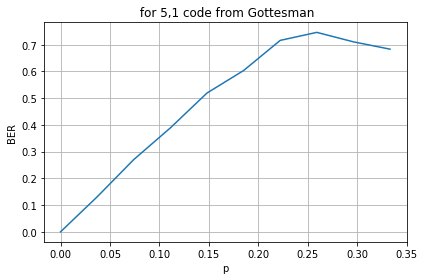

In [16]:
plt.plot(probab_list, ber_list)
plt.ylabel('BER')
plt.xlabel('p')
plt.title(' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

plt.show()